In [1]:
#This example uses the CC fraud detection code from https://www.kaggle.com/cdeotte/xgb-fraud-with-magic-0-9600
#to create a classifier. Two black-box attacks are used to show that the wrapper works with the existing ART attack
#framework.

#The data for this example can be downloaded from https://www.kaggle.com/c/ieee-fraud-detection/data

import warnings
warnings.filterwarnings('ignore')

import numpy as np, pandas as pd, os, gc
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

from art.wrappers.DataframeWrapper import DataframeWrapper
from art.classifiers import XGBoostClassifier
from art.attacks import ZooAttack, HopSkipJump

# COLUMNS WITH STRINGS
str_type = ['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain','M1', 'M2', 'M3', 'M4','M5',
            'M6', 'M7', 'M8', 'M9', 'id_12', 'id_15', 'id_16', 'id_23', 'id_27', 'id_28', 'id_29', 'id_30', 
            'id_31', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo']

# FIRST 53 COLUMNS
cols = ['TransactionID', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
       'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain',
       'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11',
       'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8',
       'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4',
       'M5', 'M6', 'M7', 'M8', 'M9']

# V COLUMNS TO LOAD DECIDED BY CORRELATION EDA
# https://www.kaggle.com/cdeotte/eda-for-columns-v-and-id
v =  [1, 3, 4, 6, 8, 11]
v += [13, 14, 17, 20, 23, 26, 27, 30]
v += [36, 37, 40, 41, 44, 47, 48]
v += [54, 56, 59, 62, 65, 67, 68, 70]
v += [76, 78, 80, 82, 86, 88, 89, 91]

#v += [96, 98, 99, 104] #relates to groups, no NAN 
v += [107, 108, 111, 115, 117, 120, 121, 123] # maybe group, no NAN
v += [124, 127, 129, 130, 136] # relates to groups, no NAN

# LOTS OF NAN BELOW
v += [138, 139, 142, 147, 156, 162] #b1
v += [165, 160, 166] #b1
v += [178, 176, 173, 182] #b2
v += [187, 203, 205, 207, 215] #b2
v += [169, 171, 175, 180, 185, 188, 198, 210, 209] #b2
v += [218, 223, 224, 226, 228, 229, 235] #b3
v += [240, 258, 257, 253, 252, 260, 261] #b3
v += [264, 266, 267, 274, 277] #b3
v += [220, 221, 234, 238, 250, 271] #b3

v += [294, 284, 285, 286, 291, 297] # relates to grous, no NAN
v += [303, 305, 307, 309, 310, 320] # relates to groups, no NAN
v += [281, 283, 289, 296, 301, 314] # relates to groups, no NAN
#v += [332, 325, 335, 338] # b4 lots NAN

cols += ['V'+str(x) for x in v]
dtypes = {}
for c in cols+['id_0'+str(x) for x in range(1,10)]+['id_'+str(x) for x in range(10,34)]: 
    dtypes[c] = 'float32'
for c in str_type: dtypes[c] = 'category'
    

In [2]:
# LOAD TRAIN
X_train = pd.read_csv('../data/IEEE-ccfraud/train_transaction.csv',index_col='TransactionID', dtype=dtypes, usecols=cols+['isFraud'])
train_id = pd.read_csv('../data/IEEE-ccfraud/train_identity.csv',index_col='TransactionID', dtype=dtypes)
X_train = X_train.merge(train_id, how='left', left_index=True, right_index=True)
# LOAD TEST
X_test = pd.read_csv('../data/IEEE-ccfraud/test_transaction.csv',index_col='TransactionID', dtype=dtypes, usecols=cols)
test_id = pd.read_csv('../data/IEEE-ccfraud/test_identity.csv',index_col='TransactionID', dtype=dtypes)
X_test = X_test.merge(test_id, how='left', left_index=True, right_index=True)
# TARGET
y_train = X_train['isFraud'].copy()
del train_id, test_id, X_train['isFraud']; x = gc.collect()
# PRINT STATUS
print('Train shape',X_train.shape,'test shape',X_test.shape)


Train shape (590540, 213) test shape (506691, 213)


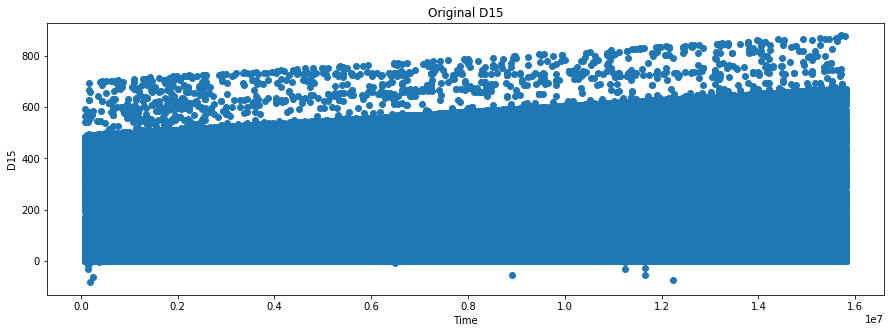

In [3]:
# PLOT ORIGINAL D
plt.figure(figsize=(15,5))
plt.scatter(X_train.TransactionDT,X_train.D15)
plt.title('Original D15')
plt.xlabel('Time')
plt.ylabel('D15')
plt.show()

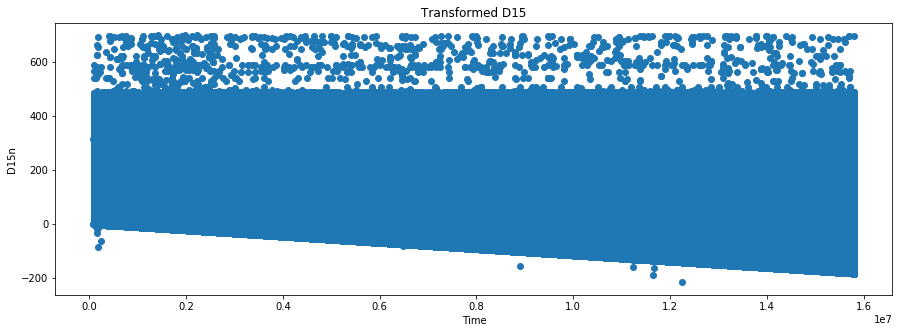

In [4]:
# NORMALIZE D COLUMNS
for i in range(1,16):
    if i in [1,2,3,5,9]: continue
    X_train['D'+str(i)] =  X_train['D'+str(i)] - X_train.TransactionDT/np.float32(24*60*60)
    X_test['D'+str(i)] = X_test['D'+str(i)] - X_test.TransactionDT/np.float32(24*60*60) 
    
# PLOT TRANSFORMED D
plt.figure(figsize=(15,5))
plt.scatter(X_train.TransactionDT,X_train.D15)
plt.title('Transformed D15')
plt.xlabel('Time')
plt.ylabel('D15n')
plt.show()

In [5]:
# LABEL ENCODE AND MEMORY REDUCE
for i,f in enumerate(X_train.columns):
    # FACTORIZE CATEGORICAL VARIABLES
    if (np.str(X_train[f].dtype)=='category')|(X_train[f].dtype=='object'): 
        df_comb = pd.concat([X_train[f],X_test[f]],axis=0)
        df_comb,_ = df_comb.factorize(sort=True)
        if df_comb.max()>32000: print(f,'needs int32')
        X_train[f] = df_comb[:len(X_train)].astype('int16')
        X_test[f] = df_comb[len(X_train):].astype('int16')
    # SHIFT ALL NUMERICS POSITIVE. SET NAN to -1
    elif f not in ['TransactionAmt','TransactionDT']:
        mn = np.min((X_train[f].min(),X_test[f].min()))
        X_train[f] -= np.float32(mn)
        X_test[f] -= np.float32(mn)
        X_train[f].fillna(-1,inplace=True)
        X_test[f].fillna(-1,inplace=True)

In [6]:
# FREQUENCY ENCODE TOGETHER
def encode_FE(df1, df2, cols):
    for col in cols:
        df = pd.concat([df1[col],df2[col]])
        vc = df.value_counts(dropna=True, normalize=True).to_dict()
        vc[-1] = -1
        nm = col+'_FE'
        df1[nm] = df1[col].map(vc)
        df1[nm] = df1[nm].astype('float32')
        df2[nm] = df2[col].map(vc)
        df2[nm] = df2[nm].astype('float32')
        print(nm,', ',end='')
        
# LABEL ENCODE
def encode_LE(col,train=X_train,test=X_test,verbose=True):
    df_comb = pd.concat([train[col],test[col]],axis=0)
    df_comb,_ = df_comb.factorize(sort=True)
    nm = col
    if df_comb.max()>32000: 
        train[nm] = df_comb[:len(train)].astype('int32')
        test[nm] = df_comb[len(train):].astype('int32')
    else:
        train[nm] = df_comb[:len(train)].astype('int16')
        test[nm] = df_comb[len(train):].astype('int16')
    del df_comb; x=gc.collect()
    if verbose: print(nm,', ',end='')
        
# GROUP AGGREGATION MEAN AND STD
# https://www.kaggle.com/kyakovlev/ieee-fe-with-some-eda
def encode_AG(main_columns, uids, aggregations=['mean'], train_df=X_train, test_df=X_test, 
              fillna=True, usena=False):
    # AGGREGATION OF MAIN WITH UID FOR GIVEN STATISTICS
    for main_column in main_columns:  
        for col in uids:
            for agg_type in aggregations:
                new_col_name = main_column+'_'+col+'_'+agg_type
                temp_df = pd.concat([train_df[[col, main_column]], test_df[[col,main_column]]])
                if usena: temp_df.loc[temp_df[main_column]==-1,main_column] = np.nan
                temp_df = temp_df.groupby([col])[main_column].agg([agg_type]).reset_index().rename(
                                                        columns={agg_type: new_col_name})

                temp_df.index = list(temp_df[col])
                temp_df = temp_df[new_col_name].to_dict()   

                train_df[new_col_name] = train_df[col].map(temp_df).astype('float32')
                test_df[new_col_name]  = test_df[col].map(temp_df).astype('float32')
                
                if fillna:
                    train_df[new_col_name].fillna(-1,inplace=True)
                    test_df[new_col_name].fillna(-1,inplace=True)
                
                print("'"+new_col_name+"'",', ',end='')
                
# COMBINE FEATURES
def encode_CB(col1,col2,df1=X_train,df2=X_test):
    nm = col1+'_'+col2
    df1[nm] = df1[col1].astype(str)+'_'+df1[col2].astype(str)
    df2[nm] = df2[col1].astype(str)+'_'+df2[col2].astype(str) 
    encode_LE(nm,verbose=False)
    print(nm,', ',end='')
    
# GROUP AGGREGATION NUNIQUE
def encode_AG2(main_columns, uids, train_df=X_train, test_df=X_test):
    for main_column in main_columns:  
        for col in uids:
            comb = pd.concat([train_df[[col]+[main_column]],test_df[[col]+[main_column]]],axis=0)
            mp = comb.groupby(col)[main_column].agg(['nunique'])['nunique'].to_dict()
            train_df[col+'_'+main_column+'_ct'] = train_df[col].map(mp).astype('float32')
            test_df[col+'_'+main_column+'_ct'] = test_df[col].map(mp).astype('float32')
            print(col+'_'+main_column+'_ct, ',end='')

In [7]:
print(np.shape(X_train))
orig_cols = X_train.columns
# TRANSACTION AMT CENTS
X_train['cents'] = (X_train['TransactionAmt'] - np.floor(X_train['TransactionAmt'])).astype('float32')
X_test['cents'] = (X_test['TransactionAmt'] - np.floor(X_test['TransactionAmt'])).astype('float32')
print('cents, ', end='')
# FREQUENCY ENCODE: ADDR1, CARD1, CARD2, CARD3, P_EMAILDOMAIN
encode_FE(X_train,X_test,['addr1','card1','card2','card3','P_emaildomain'])
# COMBINE COLUMNS CARD1+ADDR1, CARD1+ADDR1+P_EMAILDOMAIN
encode_CB('card1','addr1')
encode_CB('card1_addr1','P_emaildomain')
# FREQUENCY ENOCDE
encode_FE(X_train,X_test,['card1_addr1','card1_addr1_P_emaildomain'])
# GROUP AGGREGATE
encode_AG(['TransactionAmt','D9','D11'],['card1','card1_addr1','card1_addr1_P_emaildomain'],['mean','std'],usena=True)

(590540, 213)
cents, addr1_FE , card1_FE , card2_FE , card3_FE , P_emaildomain_FE , card1_addr1 , card1_addr1_P_emaildomain , card1_addr1_FE , card1_addr1_P_emaildomain_FE , 'TransactionAmt_card1_mean' , 'TransactionAmt_card1_std' , 'TransactionAmt_card1_addr1_mean' , 'TransactionAmt_card1_addr1_std' , 'TransactionAmt_card1_addr1_P_emaildomain_mean' , 'TransactionAmt_card1_addr1_P_emaildomain_std' , 'D9_card1_mean' , 'D9_card1_std' , 'D9_card1_addr1_mean' , 'D9_card1_addr1_std' , 'D9_card1_addr1_P_emaildomain_mean' , 'D9_card1_addr1_P_emaildomain_std' , 'D11_card1_mean' , 'D11_card1_std' , 'D11_card1_addr1_mean' , 'D11_card1_addr1_std' , 'D11_card1_addr1_P_emaildomain_mean' , 'D11_card1_addr1_P_emaildomain_std' , 

In [8]:
cols = list( X_train.columns )
cols.remove('TransactionDT')
for c in ['D6','D7','D8','D9','D12','D13','D14']:
    cols.remove(c)
    
# FAILED TIME CONSISTENCY TEST
for c in ['C3','M5','id_08','id_33']:
    cols.remove(c)
for c in ['card4','id_07','id_14','id_21','id_30','id_32','id_34']:
    cols.remove(c)
for c in ['id_'+str(x) for x in range(22,28)]:
    cols.remove(c)
print('NOW USING THE FOLLOWING',len(cols),'FEATURES.')
np.array(cols)

NOW USING THE FOLLOWING 216 FEATURES.


array(['TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card5',
       'card6', 'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain',
       'R_emaildomain', 'C1', 'C2', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9',
       'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5',
       'D10', 'D11', 'D15', 'M1', 'M2', 'M3', 'M4', 'M6', 'M7', 'M8',
       'M9', 'V1', 'V3', 'V4', 'V6', 'V8', 'V11', 'V13', 'V14', 'V17',
       'V20', 'V23', 'V26', 'V27', 'V30', 'V36', 'V37', 'V40', 'V41',
       'V44', 'V47', 'V48', 'V54', 'V56', 'V59', 'V62', 'V65', 'V67',
       'V68', 'V70', 'V76', 'V78', 'V80', 'V82', 'V86', 'V88', 'V89',
       'V91', 'V107', 'V108', 'V111', 'V115', 'V117', 'V120', 'V121',
       'V123', 'V124', 'V127', 'V129', 'V130', 'V136', 'V138', 'V139',
       'V142', 'V147', 'V156', 'V160', 'V162', 'V165', 'V166', 'V169',
       'V171', 'V173', 'V175', 'V176', 'V178', 'V180', 'V182', 'V185',
       'V187', 'V188', 'V198', 'V203', 'V205', 'V207', 'V209', 'V210',
       '

In [9]:
#TRAIN 75% PREDICT 25%
idxT = X_train.index[:3*len(X_train)//4]
idxV = X_train.index[3*len(X_train)//4:]

import xgboost as xgb
print("XGBoost version:", xgb.__version__)


clf = xgb.XGBClassifier( 
    n_estimators=2000,
    max_depth=12, 
    learning_rate=0.02, 
    subsample=0.8,
    colsample_bytree=0.4, 
    missing=-1, 
    eval_metric='auc',
    # USE CPU
    #nthread=4,
    #tree_method='hist' 
    # USE GPU
    tree_method='gpu_hist' 
)
h = clf.fit(DataframeWrapper(X_train.loc[idxT,cols]), y_train[idxT].values, 
    eval_set=[(X_train.loc[idxV,cols].values,y_train[idxV].values)],
    verbose=50, early_stopping_rounds=100)

XGBoost version: 0.90
[0]	validation_0-auc:0.787465
Will train until validation_0-auc hasn't improved in 100 rounds.
[50]	validation_0-auc:0.87831
[100]	validation_0-auc:0.894923
[150]	validation_0-auc:0.907818
[200]	validation_0-auc:0.918978
[250]	validation_0-auc:0.925765
[300]	validation_0-auc:0.930157
[350]	validation_0-auc:0.933913
[400]	validation_0-auc:0.935322
[450]	validation_0-auc:0.935882
[500]	validation_0-auc:0.936412
[550]	validation_0-auc:0.936245
[600]	validation_0-auc:0.936186
Stopping. Best iteration:
[510]	validation_0-auc:0.936498



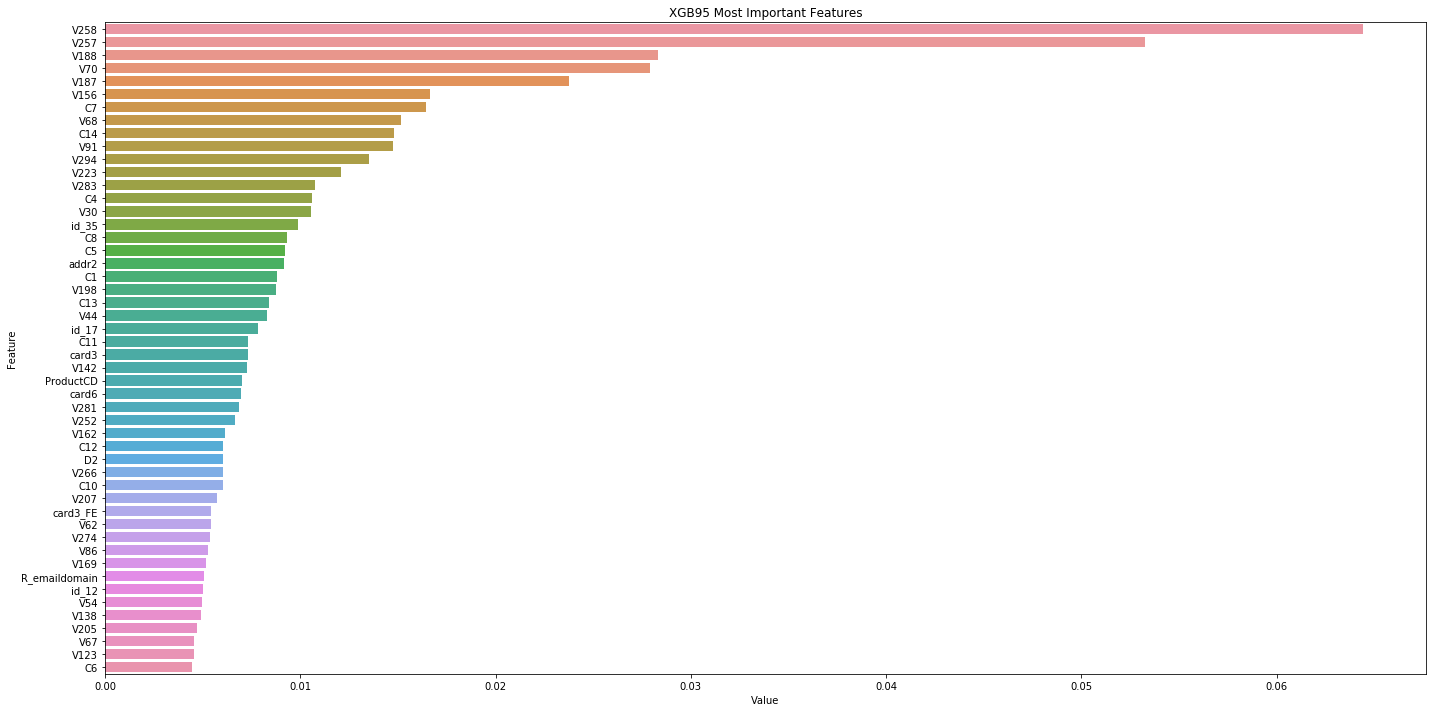

In [10]:
feature_imp = pd.DataFrame(sorted(zip(clf.feature_importances_,cols)), columns=['Value','Feature'])
plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).iloc[:50])
plt.title('XGB95 Most Important Features')
plt.tight_layout()
plt.show()
#del clf, h; 
x=gc.collect()

In [11]:
# Create ART classifier for XGBoost
art_classifier = XGBoostClassifier(model=clf, nb_features=len(cols), nb_classes=2)

norm_ind = np.where(y_train == 0)[0][:1000]
fraud_ind = np.where(y_train == 1)[0][:1000]
x_norm = X_train[cols].iloc[norm_ind].values
x_fraud = X_train[cols].iloc[fraud_ind].values
orig_labels = np.append(y_train.iloc[norm_ind], y_train.iloc[fraud_ind],axis=0)

print(np.shape(x_norm), np.shape(x_fraud), np.shape(orig_labels))

#Ind of correct predictions
train_preds = clf.predict(X_train[cols].values)
true_norm_ind = np.where(np.logical_and(train_preds == 1,y_train == 0))[0]
true_fraud_ind = np.where(np.logical_and(train_preds == 1,y_train == 1))[0]

(1000, 216) (1000, 216) (2000,)


In [12]:
# Create ART Zeroth Order Optimization attack
zoo = ZooAttack(classifier=art_classifier, confidence=0.0, targeted=False, learning_rate=1e-1, max_iter=100,
                binary_search_steps=20, initial_const=1e-3, abort_early=True, use_resize=False, 
                use_importance=False, nb_parallel=10, batch_size=1, variable_h=0.05)


x_adv_source = DataframeWrapper(X_train[cols].iloc[true_fraud_ind[:10]])
print("Before Attack Probs:")
print(art_classifier.predict(x_adv_source))
x_adv = zoo.generate(x_adv_source)
print("Done with Attack!")
print("After Attack Probs:")
print(art_classifier.predict(x_adv))

print("L-p distance metrics")
print( "L-Inf Distance", np.max(np.abs(x_adv_source-x_adv)))
print( "L-2 Distance", np.mean(np.linalg.norm(x_adv_source-x_adv,axis=1)))
print( "L-0 Distance", np.mean(np.sum(np.array(x_adv_source,dtype=np.float32) != x_adv,axis=1)))
print()

Before Attack Probs:
[[0.15009552 0.8499045 ]
 [0.16122067 0.83877933]
 [0.10376835 0.89623165]
 [0.4849124  0.5150876 ]
 [0.00891978 0.9910802 ]
 [0.27214104 0.72785896]
 [0.27708876 0.72291124]
 [0.03488499 0.965115  ]
 [0.01644242 0.9835576 ]
 [0.2927391  0.7072609 ]]
Done with Attack!
After Attack Probs:
[[0.5364984  0.46350157]
 [0.606274   0.39372596]
 [0.6475572  0.3524428 ]
 [0.5129016  0.4870984 ]
 [0.50302523 0.49697477]
 [0.5101844  0.48981556]
 [0.51248074 0.48751923]
 [0.5028765  0.49712345]
 [0.5280664  0.47193357]
 [0.553253   0.446747  ]]
L-p distance metrics
L-Inf Distance 11.069313257932663
L-2 Distance 6.490733631603949
L-0 Distance 19.2



In [13]:
# Create ART HopSkipJump attack
attack = HopSkipJump(classifier=art_classifier, targeted=False, max_iter=0, max_eval=1000, init_eval=10)
iter_step = 10

orig_input = DataframeWrapper(X_train[cols].iloc[true_fraud_ind[0]])
x_adv = None

print("Original label %d" %  np.argmax(art_classifier.predict(orig_input)[0]))
for i in range(10):
    x_adv = attack.generate(x=orig_input, x_adv_init=x_adv)

    #clear_output()
    print("Adversarial input at step %d." % (i * iter_step), "L2 error", 
          np.linalg.norm(x_adv[0] - orig_input),
          "and class label %d." % np.argmax(art_classifier.predict(x_adv)[0]))
    
    attack.max_iter = iter_step

Original label 1
Adversarial input at step 0. L2 error 1450.3815841431542 and class label 0.
Adversarial input at step 10. L2 error 4.6470332372606543e-07 and class label 0.
Adversarial input at step 20. L2 error 4.4959798023271185e-07 and class label 0.
Adversarial input at step 30. L2 error 4.433313975458305e-07 and class label 0.
Adversarial input at step 40. L2 error 4.4033602134057236e-07 and class label 0.
Adversarial input at step 50. L2 error 4.3955769125544744e-07 and class label 0.
Adversarial input at step 60. L2 error 4.3835495739055566e-07 and class label 0.
Adversarial input at step 70. L2 error 4.3673076522575137e-07 and class label 0.
Adversarial input at step 80. L2 error 4.3715439056397567e-07 and class label 0.
Adversarial input at step 90. L2 error 4.360912885808231e-07 and class label 0.
